In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

plt.style.use('classic')

VANDAL = "/home/lexi/vandal"
CONTRACT_DIR = "/home/lexi/eth-ramdisk/ethscrape-2018-08-30-b6237983-uniq"
BALANCES = "/home/lexi/eth-ramdisk/balances"
MD5SUMS = "/home/lexi/eth-ramdisk/md5sums"
# produces balances file with: cd %s ; grep -r contract.balance"%location

In [2]:
import sys
from os.path import abspath, dirname, join, basename

# Prepend .. to $PATH so the project modules can be imported below
sys.path.insert(0, VANDAL)

import src.opcodes as opcodes
import src.blockparse as blockparse
import src.settings as settings

In [3]:
# Build dictionary of contract md5sums

contract_md5s = {}
md5_contracts = {}

with open(MD5SUMS) as md5sums:
    for l in md5sums:
        contract_id = l.split('./')[1].split('_')[0]
        md5 = l.split()[0]
        contract_md5s[contract_id] = md5
        if md5 not in md5_contracts:
            md5_contracts[md5] = [contract_id]
        else:
            md5_contracts[md5].append(contract_id)

In [4]:
# Build balances dictionary
bals = {}

with open(BALANCES) as balances:
    for l in balances:
        contract_id = l.split('_')[0]
        contract_balance = float(l.split('"contract_balance": "')[-1].split('"')[0])
        bals[contract_id] = contract_balance

In [5]:
# Calculates the real balance controlled by this bytecode,
# which is the sum of balances of all accounts with identical bytecode
def real_balance(contract_id):
    bal = float(0)
    md5 = contract_md5s[contract_id]
    for c in md5_contracts[md5]:
        bal += bals[c]
    return bal

In [6]:
# Disassemble and find num basic blocks and balance for each contract
import glob

data = {}

contracts = glob.glob(join(CONTRACT_DIR, '*_runtime.hex'))

# TODO: remove for real data
#contracts = contracts[:10000]

from multiprocessing import Pool

def process_contract(fname):
    with open(fname) as infile:
        bytecode = ''.join(l.strip() for l in infile if len(l.strip()) > 0)
        # parse bytecode and create basic blocks
        blocks = blockparse.EVMBytecodeParser(bytecode).parse()
        contract_id = basename(fname).split('_')[0]
        return {contract_id: {
            "blocks": len(blocks),
            "balance": real_balance(contract_id),
            "dupes": len(md5_contracts[contract_md5s[contract_id]])}}

with Pool(processes=32) as pool:
    for r in pool.map(process_contract, contracts):
        data.update(r)

/home/lexi/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


<Figure size 432x288 with 0 Axes>

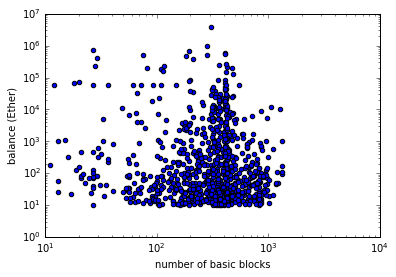

In [64]:
df = pd.DataFrame.from_dict(data, orient='index')

# TODO: exclude contracts which have selfdestructed

column_names = dict([('blocks','number of basic blocks'), ('balance', 'balance (Ether)')])
plt.figure()
df = df.drop(columns=['dupes'])
df[df['blocks'] > 10][df['balance'] > 10].rename(columns = dict(column_names)).plot.scatter(*column_names.values(), logy = True, logx = True)
#plt.show()
plt.xlim(xmin=10)
plt.savefig('basic_blocks_vs_balance.pdf')

ignore:

```
# Plot number of contracts for each unique bytecode

num_contracts = {md5: len(md5_contracts[md5]) for md5 in md5_contracts}

column_names = {0: 'number of occurrences'}

df = pd.DataFrame.from_dict(num_contracts, orient='index')
df = df.sort_values(by=[0])
df.index.rename('unique bytecode', inplace=True)

from scipy.stats import mstats

data = pd.Series(mstats.winsorize(df[0]))

data.plot.hist(logy=True, logx=True, bins=1000)

#ax = df[df[0] > 10].rename(columns=column_names).plot.hist(logy=True, logx=True, legend=False, bins=10000)
#ax.set_ylabel('number of occurrences')
```

In [69]:
df = pd.DataFrame.from_dict(data, orient='index')

# TODO: exclude contracts which have selfdestructed

column_names = dict([('blocks','number of basic blocks'), ('dupes', 'duplication frequency')])
plt.figure()
df = df.drop(columns=['balance'])
df = df[df['blocks'] > 10][df['dupes'] > 10].rename(columns = dict(column_names))
df.plot.scatter(*column_names.values(), logy = True, logx = True)
#plt.show()
#plt.xlim(xmin=10, xmax=10**4+4500)
plt.savefig('basic_blocks_vs_duplication.pdf')

/home/lexi/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


<Figure size 432x288 with 0 Axes>

In [76]:
data2 = {md5: {"balance": sum([bals[cid] for cid in md5_contracts[md5]]), "dupes": len(md5_contracts[md5])} for md5 in md5_contracts}

In [89]:
df = pd.DataFrame.from_dict(data2, orient='index')

# TODO: exclude contracts which have selfdestructed
column_names = dict([('dupes','duplication frequency'), ('balance', 'balance (Ether)')])

plt.figure()
df[df['dupes'] > 1][df['balance'] > 0].rename(columns = dict(column_names)).plot.scatter(*column_names.values(), logy = True, logx = True)
#plt.show()
plt.xlim(xmin=1)
plt.savefig('balance_vs_duplication.pdf')

/home/lexi/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


<Figure size 432x288 with 0 Axes>